# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Гарипов Тимур Исмагилевич

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [2]:
data_train = pd.read_csv('./data/unimel_train.csv')
data_test = pd.read_csv('./data/unimel_test.csv')
y_train = np.array(data_train['Grant.Status'])
y_test = np.array(data_test['Grant.Status'])
del data_train['Grant.Status']

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

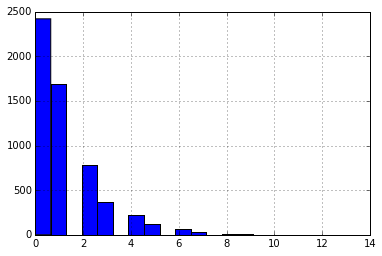

In [3]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

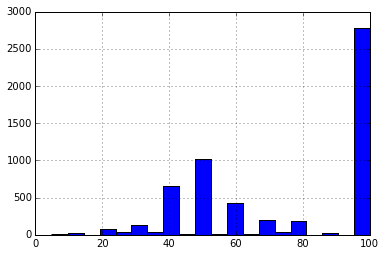

In [4]:
data_train['RFCD.Percentage.1'].hist(bins=20)

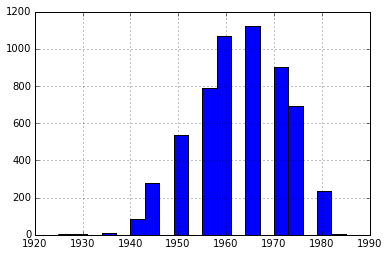

In [5]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

По построенным гистограммам видно, что признаки измеряются в разных масштабах. Это может негативно сказаться на качестве работы градиентных методов оптимизации. 

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [6]:
print('1. ' +  str(data_train.isnull().sum().sum()))
print('2. ' + str((data_train.isnull().sum(axis=1) > 0).sum()))
print('3. ' + str((data_train.isnull().sum() > 0).sum()))

1. 26843
2. 5879
3. 38


Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [7]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [8]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}]


In [9]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
transformer.fit_transform(simple_data_dict)

array([[ 1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.]])

Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [10]:
def transform_data(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']        
    numeric = data[numeric_cols].copy()    
    numeric.fillna(0, inplace=True)
    
    if (not is_test):
        numeric = scaler.fit_transform(numeric)
    else:
        numeric = scaler.transform(numeric)
    numeric = np.array(numeric)
                
    categorial = data[data.columns.difference(numeric_cols)].copy()
    categorial.fillna('nan', inplace=True)
    categorial = categorial.astype(str)
    categorial = categorial.T.to_dict().values()
    if (not is_test):
        categorial = transformer.fit_transform(categorial)
    else:
        categorial = transformer.transform(categorial)    
    return np.hstack([numeric, categorial]), scaler, transformer                      

Применяем функцию к данным:

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [12]:
print X.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [13]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
def scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]    
    return roc_auc_score(y, y_pred)
gs = GridSearchCV(LogisticRegression(), {'C': C_grid}, scoring=scorer, 
                  cv=cv, n_jobs=1, refit=True, verbose=1)
gs.fit(X, y_train)


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=sklearn.cross_validation.KFold(n=6095, n_folds=5, shuffle=True, random_state=241),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function scorer at 0x7f0d1230f140>, verbose=1)

In [15]:
print('Best C: ' + str(gs.best_params_['C']) + '. Best CV score: ' + str(gs.best_score_))
print('Test score: ' + str(scorer(gs, X_test, y_test)))

Best C: 0.1. Best CV score: 0.882391493452
Test score: 0.880349059919


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [16]:
for C in C_grid:
    clf = LogisticRegression(penalty='l1', C=C)
    clf.fit(X, y_train)
    print('C: ' + str(C) + '. Coeff num: ' + str(np.sum(np.abs(clf.coef_) > 1e-5)))                             

C: 0.001. Coeff num: 0
C: 0.01. Coeff num: 9
C: 0.1. Coeff num: 58
C: 1.0. Coeff num: 666
C: 10.0. Coeff num: 2456
C: 100.0. Coeff num: 2968


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [17]:
clf = LogisticRegression(penalty='l1', C=0.01) 
clf.fit(X, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
num = np.sum(np.abs(clf.coef_) > 1e-5)
print('Test score: ' + str(roc_auc_score(y_test, y_pred)) + '. Coeff num: ' + str(num))

Test score: 0.852572101153. Coeff num: 9


# Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [18]:
proba = gs.predict_proba(X_test)[:, 1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss

print('AUC-ROC: ' + str(roc_auc_score(y_test, proba)))
print('AUC-PR: ' + str(average_precision_score(y_test, proba)))
print('Log loss: ' + str(log_loss(y_test, proba)))

AUC-ROC: 0.880349059919
AUC-PR: 0.838758043121
Log loss: 0.442737702403


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

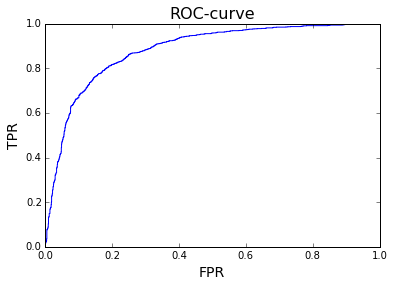

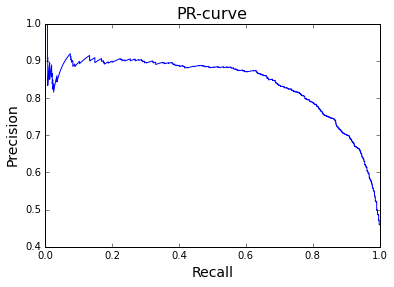

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title('ROC-curve', fontsize=16)
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, proba)
plt.plot(recall, precision)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('PR-curve', fontsize=16)
plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. 

Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [21]:
ind = np.where(recall >= 0.9)[0][np.argmax(precision[recall >= 0.9])]
print('Recall >= 90%')
print('Precision: ' + str(precision[ind]))
print('Threshold: ' + str(thresholds[ind]))

Recall >= 90%
Precision: 0.701948051948
Threshold: 0.314958503338


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [22]:
print('F-score: ' + str(2.0 * precision[ind] * recall[ind] / (precision[ind] + recall[ind])))

F-score: 0.7887632251


#### Значение F-меры не велико из-за маленькой точности.

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [23]:
ind = np.where(precision >= 0.8)[0][np.argmax(recall[precision >= 0.8])]
print('Precision >= 80%')
print('Recall: ' + str(recall[ind]))
print('Threshold: ' + str(thresholds[ind]))

Precision >= 80%
Recall: 0.776019983347
Threshold: 0.529039415988


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [24]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

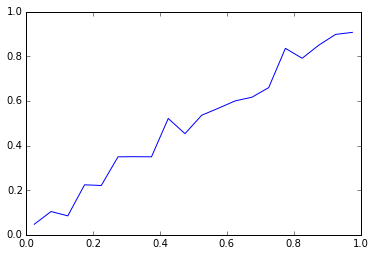

In [25]:
clf = LogisticRegression(C=1.0)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

#### Полученная кривая почти диагональна.

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

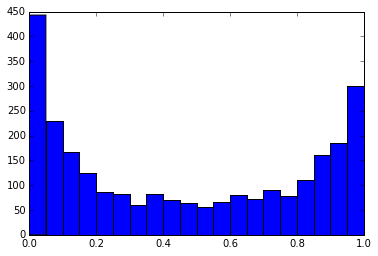

In [26]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [27]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

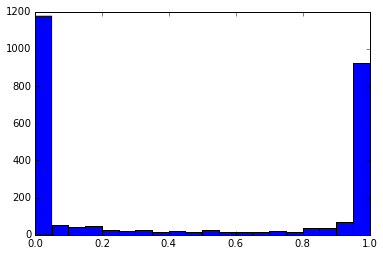

In [28]:
plt.hist(preds, bins=20)
plt.show()

Для большинства объектов предсказываются вероянности близкие к 0 или к 1. Видимо куоно-линейная функция потерь стремится хорошо разделить классы, но не стремится предсказать вероятности классов.

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

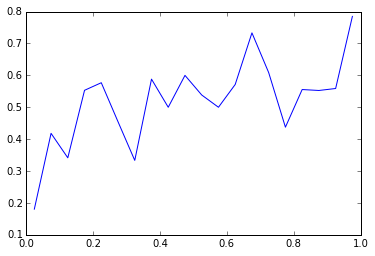

In [29]:
plot_calibration_curve(y_test, preds)

Кривая сильно отколняется от диагонали.

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

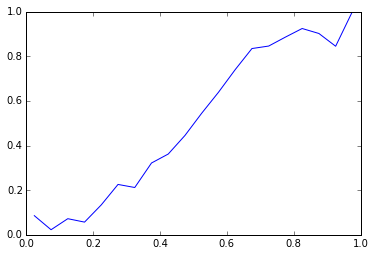

In [30]:
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(SGDClassifier(loss='hinge'))
calibrated.fit(X, y_train)
preds = calibrated.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

После калибровки кривая стала больше походить на диагональную.

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [33]:
X_train_new = np.hstack([X, np.ones((X.shape[0], 1))])
X_test_new = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
y_train_new = y_train * 2 - 1
y_test_new = y_test * 2 - 1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [34]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    dot = np.dot(X, w[:, np.newaxis])
    return 1.0 / (1.0 + np.exp(-dot))

In [35]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    M = (np.dot(X, w[:, np.newaxis]) * y[:, np.newaxis]).ravel()
    return np.sum(np.log(1.0 + np.exp(-M))) / y.size

In [36]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    M = (np.dot(X, w[:, np.newaxis]) * y[:, np.newaxis]).ravel()
    c = (-1.0 / (1.0 + np.exp(M))) * y
    return np.sum(c[:, np.newaxis] * X , axis=0) / y.size

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [37]:
def grad_descent(X, y, step_size, max_iter):
    w = np.zeros(X.shape[1])    
    obj_curve = []
    obj_curve.append(get_func(w, X, y))
    for i in range(1, max_iter + 1):
        grad = get_grad(w, X, y)        
        w += -step_size * grad
        obj_curve.append(get_func(w, X, y))
        if (np.sqrt(np.sum(grad ** 2)) < 1e-6):
            break
    return w, np.array(obj_curve)

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

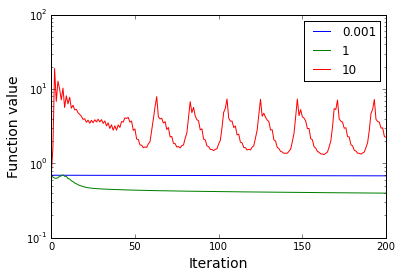

In [123]:
best_func = 1e10
coef = None
for step in [0.001, 1, 10]:
    w, obj_curve = grad_descent(X_train_new, y_train_new, step, 200)
    if (best_func > obj_curve[-1]):
        coef = w
        best_func = obj_curve[-1]
    plt.semilogy(np.arange(obj_curve.size), obj_curve, label=str(step))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Function value', fontsize=14)
plt.legend()
plt.show()

Графики зависимости функции потерь от номера итерации градиентного спуска показывают следуюшее. 

Шаг 10 оказался слишком большим, и метод не может сойтись с таким шагом. 

Шаг 0.001 оказался слишком мелким, с таким шагом итерация метода почти не уменьшает значение функции потерь. 

Шаг 1 оказался оптимальным, с таким шагом удалось уменьшить значение функции потерь. 

In [132]:
preds = make_pred(X_test_new, coef)
print('AUC-ROC: ' + str(roc_auc_score(y_test, preds)))

AUC-ROC: 0.87576364597


Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [38]:
def sgd(X, y, step_size, max_iter):
    w = np.zeros(X.shape[1])    
    obj_curve = []
    obj_curve.append(get_func(w, X, y))
    for i in range(1, max_iter + 1):
        ind = np.random.randint(0, y.size - 1)        
        grad = get_grad(w, X[ind, :], np.array([y[ind]]))        
        w += -step_size * grad
        obj_curve.append(get_func(w, X, y))
        if (np.sqrt(np.sum(grad ** 2)) < 1e-6):
            break
    return w, np.array(obj_curve)

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

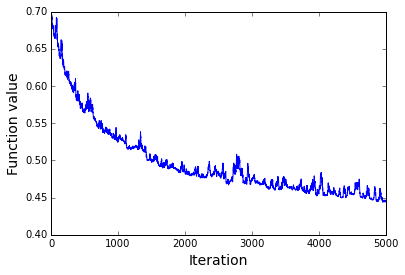

In [53]:
w, obj_curve = sgd(X_train_new, y_train_new, 0.01, 5000)
plt.plot(np.arange(obj_curve.size), obj_curve)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Function value', fontsize=14)
plt.show()

In [54]:
preds = make_pred(X_test_new, w)
print('AUC-ROC: ' + str(roc_auc_score(y_test, preds)))

AUC-ROC: 0.858320674697


Метод сделал на порядок больше итераций, чем FGD, но получил меньшее качесвто 

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [31]:
class dummy_scaler:
    def fit_transform(self, X):
        return X
    def transform(self, X):
        return X
scaler = dummy_scaler()
transformer = DictVectorizer(sparse=False)
X_train_non_scaled, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test_non_scaled, _, _ = transform_data(data_test, scaler, transformer, True)
X_train_non_scaled = np.hstack([X_train_non_scaled, np.ones((X.shape[0], 1))])
X_test_non_scaled = np.hstack([X_test_non_scaled, np.ones((X_test.shape[0], 1))])

In [50]:
w, obj_curve = grad_descent(X_train_non_scaled, y_train_new, 0.000001, 200)

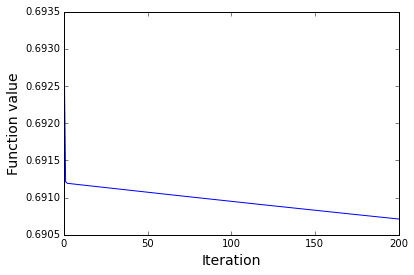

In [51]:
plt.plot(np.arange(obj_curve.size), obj_curve)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Function value', fontsize=14)
plt.show()

In [52]:
preds = make_pred(X_test_non_scaled, w)
print('AUC-ROC: ' + str(roc_auc_score(y_test, preds)))

AUC-ROC: 0.511680834904


Без масштабирования признаков, метод сходится только при очень маленькой длине шага. При этом качестве сильно хуже, чем при масштабировании.

Здесь вы можете поделиться своими мыслями по поводу этой части.

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [55]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [56]:
from sklearn.linear_model import Ridge
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for alpha in alpha_grid:
    regressor = Ridge(alpha=alpha)
    regressor.fit(X, y)
    y_pred = regressor.predict(X_test)
    mse = np.mean((y_test - y_pred) ** 2)
    print('alpha = ' + str(alpha) + ' . mse = ' + str(mse))


alpha = 0.001 . mse = 3120.09020578
alpha = 0.01 . mse = 3107.38818648
alpha = 0.1 . mse = 3096.03015101
alpha = 1.0 . mse = 3399.40482339
alpha = 10.0 . mse = 4577.48210429
alpha = 100.0 . mse = 5210.22019186


Наилучшее щначение достигается при $\alpha=0.1$

Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [57]:
from sklearn.metrics import r2_score
regressor = Ridge(alpha=0.1)
regressor.fit(X, y)
y_pred = regressor.predict(X_test)
rmse = math.sqrt(np.mean((y_test - y_pred) ** 2))
r2 = r2_score(y_test, y_pred)
print('rmse = ' + str(rmse))
print('r2_score = ' + str(r2))

rmse = 55.6419819113
r2_score = 0.417024184822


Значение коэффициента детерминации показывает, что модель достаточна далека от идеальной. Можно сказать, что она занимает промежуточное положение между алгоритмом, который для всех объектов предсказывает среднее по тренировочной выборке значение $y$, и идеальным алгоритмом.